### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import gzip  # Trabalha com arquivos comprimidos no formato .gz (gzip)
import pandas as pd  # Manipulação de dados em formato de tabela (DataFrame)
import numpy as np  # Operações matemáticas e estruturas de arrays eficientes
import matplotlib.pyplot as plt  # Criação de gráficos básicos e visualizações
import seaborn as sns  # Gráficos estatísticos com estilo mais bonito (baseado no matplotlib)
from sklearn.metrics import (
    roc_auc_score,        # Métrica AUC para avaliação de classificadores
    confusion_matrix,     # Matriz de confusão para avaliação de modelos
    make_scorer,          # Criação de métricas personalizadas
    f1_score              # Métrica F1 que combina precisão e recall
)
from sklearn.linear_model import LogisticRegression  # Algoritmo de regressão logística (classificação binária)
from sklearn.compose import make_column_selector as selector  # Seleciona colunas com base em tipo ou nomes
from sklearn.impute import SimpleImputer  # Preenchimento de valores ausentes (missing data)
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Padronização de dados e codificação categórica
from sklearn.compose import ColumnTransformer  # Aplica transformações diferentes em colunas distintas
from sklearn.pipeline import Pipeline  # Cria sequência ordenada de etapas (pipeline de modelagem)
from sklearn.datasets import fetch_openml  # Baixa datasets públicos do OpenML direto pro seu notebook
from sklearn.model_selection import train_test_split  # Divide os dados entre treino e teste

#Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]  # Define o tamanho padrão dos gráficos como 10x7 polegadas
plt.rcParams['font.size'] = 15            # Define o tamanho padrão da fonte nos gráficos matplotlib
sns.set(color_codes=True)                 # Ativa uso de códigos de cor (ex: 'b' para azul) no Seaborn
sns.set(font_scale=1.5)                   # Aumenta a escala do tamanho da fonte nos gráficos do Seaborn
sns.set_palette("bright")                 # Define paleta de cores vibrantes para os gráficos do Seaborn
sns.set_style("whitegrid")                # Aplica estilo com fundo branco e linhas de grade (ideal pra visualização)

In [9]:
from tqdm import tqdm # Barra de progresso para loops (tqdm é uma biblioteca que facilita a visualização do progresso de loops longos)



In [10]:


dataset = fetch_openml(name = 'adult', as_frame =True)
df, y = dataset.data, dataset.target

/home/datascience/conda/automlx_p38_cpu_v2/lib/python3.8/site-packages/sklearn/datasets/_openml.py:292: UserWarning: Multiple active versions of the dataset matching the name adult exist. Versions may be fundamentally different, returning version 1.
  warn(


In [11]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States
1,3,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States
2,2,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States
3,3,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States
4,1,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba


In [12]:

class_type = y.unique();
print(f"\nClass type: {class_type[0]} - {class_type[1]}")

df[y.name] = y.astype('category').cat.codes  # Converte a variável alvo para o tipo categórico

r = len(df)

print(f"DataSet has {r} rows and {df.shape[1]} columns")

for r in y.unique():
    print(f"\nClass {r} has {len(df[df[y.name] == r])} rows")




Class type: <=50K - >50K
DataSet has 48842 rows and 15 columns

Class <=50K has 0 rows

Class >50K has 0 rows


In [14]:
pd.DataFrame({'Data types': df.dtypes}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
Data types,category,category,float64,category,float64,category,category,category,category,category,category,category,category,category,int8


In [15]:
pd.DataFrame({'Missing values': df.isnull().sum() * 100/ len(df)}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
Missing values,0.0,5.730724,0.0,0.0,0.0,0.0,5.751198,0.0,0.0,0.0,0.0,0.0,0.0,1.754637,0.0


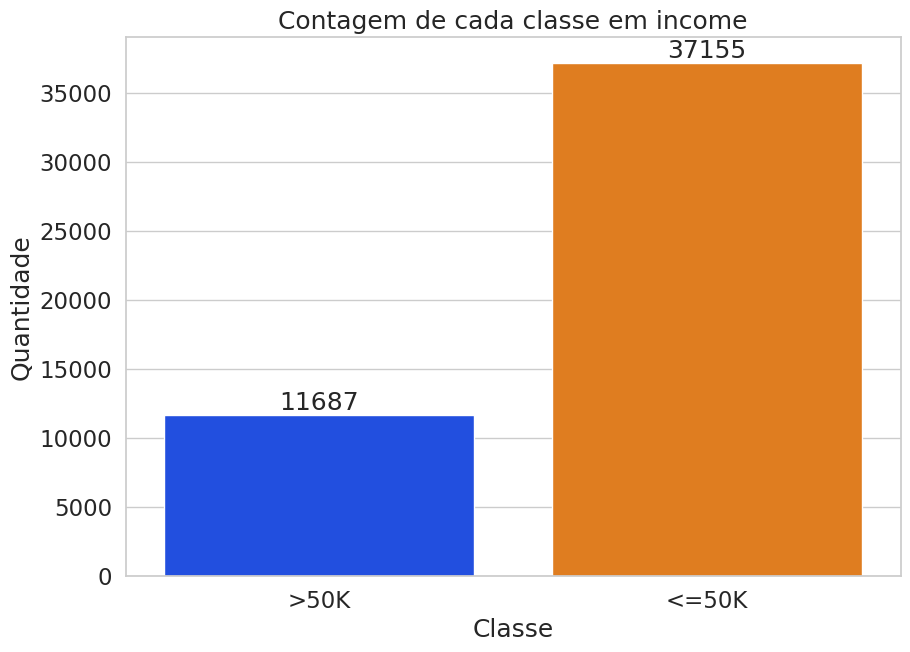

In [13]:
y_df = pd.DataFrame(y);
y_df.columns = ['income']  # Renomeia a coluna do DataFrame de y para o nome original

ax = sns.countplot(x='income', data=y_df) # Plota a contagem de cada classe na variável alvo 'income'
ax.bar_label(ax.containers[0])  # Adiciona rótulos de contagem em cima de cada barra do gráfico

plt.title('Contagem de cada classe em income')  # Define o título do gráfico
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.show()

In [16]:
numeric_columns = ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
for col in df.columns:
    if col in numeric_columns:
        df[col] = df[col].astype('int')

# Map y to binary and convert to int
y_binary = y.map({'>50K': 1, '<=50K': 0}).astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df, y_binary, train_size=0.7, random_state=42)

X_train.shape, X_test.shape  # Divide os dados em conjuntos de treino e teste, mapeando as classes para 1 e 0

((34189, 15), (14653, 15))

In [18]:
import automl  # Importa o pacote completo 'automl', que pode conter métodos para AutoML (automatizar experimentos de machine learning)

from automl import init  # Importa especificamente a função 'init' do pacote — geralmente usada para inicializar ou configurar o ambiente AutoML
init(engine='local') # Inicializa o ambiente AutoML localmente

[2025-08-03 02:18:15,733] [automl.xengine] Local ProcessPool execution (n_jobs=1)


In [20]:
est1 = automl.Pipeline(task = 'classification') # Cria um pipeline de automação de machine learning para classificação
est1.fit(X_train, y_train)  # Treina o modelo com os dados de treino

[2025-08-03 02:18:20,767] [automl.pipeline] Random state (7) is used for model builds
[2025-08-03 02:18:20,790] [automl.pipeline] Dataset shape: (34189, 15)
[2025-08-03 02:18:20,799] [automl.pipeline] Running Auto-Preprocessing
[2025-08-03 02:18:21,005] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (34189, 16), cv: 5
[2025-08-03 02:18:21,137] [automl.pipeline] SVC, KNeighborsClassifier are disabled for datasets with > 10K samples or > 1K features
[2025-08-03 02:18:21,138] [automl.pipeline] Running Model Selection
[2025-08-03 02:18:55,288] [automl.pipeline] Model Selection completed. Selected model: ['DecisionTreeClassifier']
[2025-08-03 02:18:55,290] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (34189, 16), Valid Shape: None, CV: 5, Class counts: [26046  8143]
[2025-08-03 02:18:56,346] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (34189, 16), Valid Shape: None, CV: [(6738, 6838), (6738, 6838), (6738, 6838), (6738, 6838), (6738

Pipeline(model_list=['DecisionTreeClassifier', 'ExtraTreesClassifier',
                     'GaussianNB', 'LGBMClassifier', 'LogisticRegression',
                     'RandomForestClassifier', 'SVC', 'XGBClassifier',
                     'TorchMLPClassifier', 'CatBoostClassifier'])

In [27]:
y_proba = est1.predict_proba(X_test)
score_default = roc_auc_score(y_test,y_proba[:,1])

print(f'Score on test data: {score_default}')

Score on test data: 1.0


In [21]:
est1.print_summary()

Training Dataset size,"(34189, 15)"
Validation Dataset size,None
CV,5
Optimization Metric,neg_log_loss
Selected Features,"Index(['class'], dtype='object')"
Selected Algorithm,DecisionTreeClassifier
Time taken,41.5232
Selected Hyperparameters,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'min_weight_fraction_leaf': 0.0, 'random_state': 7, 'splitter': 'best'}"
AutoML version,23.1.1
Python version,"3.8.16 (default, Mar 2 2023, 03:21:46) \n[GCC 11.2.0]"


Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage (GB)
DecisionTreeClassifier_AS,5000,16,-9.9920e-16,"{'class_weight': None, 'max_features': 1.0, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",0.0710,0.0
DecisionTreeClassifier_HT,34189,1,-9.9920e-16,"{'class_weight': 'balanced', 'max_features': 1.0, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",0.0556,"(0.0, None)"
DecisionTreeClassifier_HT,34189,1,-9.9920e-16,"{'class_weight': None, 'max_features': 1.0, 'min_samples_leaf': 0.045492188842110606, 'min_samples_split': 0.00125}",0.0303,"(0.0, None)"
DecisionTreeClassifier_HT,34189,1,-9.9920e-16,"{'class_weight': None, 'max_features': 1.0, 'min_samples_leaf': 0.04548718913460234, 'min_samples_split': 0.00125}",0.0315,"(0.0, None)"
DecisionTreeClassifier_HT,34189,1,-9.9920e-16,"{'class_weight': None, 'max_features': 1.0, 'min_samples_leaf': 0.0006299997075082629, 'min_samples_split': 0.00125}",0.0273,"(0.0, None)"
...,...,...,...,...,...,...
CatBoostClassifier_AS,5000,16,-3.3947e-05,"{'iterations': 235, 'learning_rate': 0.787168, 'l2_leaf_reg': 2.567326, 'feature_border_type': 'UniformAndQuantiles', 'model_size_reg': 3.85132, 'leaf_estimation_method': 'Newton', 'leaf_estimation_iterations': 1, 'colsample_bylevel': 0.096865, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'auto_class_weights': 'SqrtBalanced'}",1.0320,0.0
ExtraTreesClassifier_AS,5000,16,-4.7179e-05,"{'n_estimators': 100, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",1.4646,0.0
LGBMClassifier_AS,5000,16,-1.1637e-04,"{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",0.4894,0.0
XGBClassifier_AS,5000,16,-1.9554e-04,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.6047,0.0
